# Prediction of the FIFA World Cup

The code below follows mainly a Kaggle tutorial: Predicting FIFA 2022 World Cup with ML (https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml/notebook). This tutorial is used to provide a code base that allows us to discuss three claims from the paper we are exploring.

Common Imports

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# import matplotlib.ticker as ticker
# import matplotlib.ticker as plticker
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

Install Kaggle

In [79]:
 !pip install -q kaggle

To run this block of code, you need a Kaggle account. 
1. Create a Kaggle account
2. Go to Settings - Account - API - Create new token. 
3. Upload this json file when prompted by colab

In [80]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tazscotttalib","key":"729a8de34a0638797334e789eaa8252f"}'}

In [81]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 1. Datasets



### 1.1 GDP per capita
This section consists of downloading GDP per capita throughout the years from 

In [82]:
!curl -o gdp_per_capita.xlsx 'https://unstats.un.org/unsd/amaapi/api/File/9'

gdp_per_capita = pd.read_excel("gdp_per_capita.xlsx")

print("GDP per capita:")
print(gdp_per_capita.head())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  184k  100  184k    0     0   213k      0 --:--:-- --:--:-- --:--:--  213k
GDP per capita:
  Per Capita GDP at current prices in US Dollars (all countries)   Unnamed: 1  \
0                                                NaN                      NaN   
1                                          CountryID                  Country   
2                                                  4              Afghanistan   
3                                                  8                  Albania   
4                                                 12                  Algeria   

    Unnamed: 2   Unnamed: 3   Unnamed: 4   Unnamed: 5   Unnamed: 6  \
0          NaN          NaN          NaN          NaN          NaN   
1  1970.000000  1971.000000  1972.000000  1973.000000  1974.000000   
2   161.019274   164.566181   146.003034   147.099

## 1.2 Population

In [83]:
!curl -o population.xlsx 'https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel'

population = pd.read_excel("population.xlsx")

print("Population:")
print(population.head())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  243k  100  243k    0     0   867k      0 --:--:-- --:--:-- --:--:--  870k
Population:
                   Data Source World Development Indicators  \
0            Last Updated Date          2023-03-01 00:00:00   
1                          NaN                          NaN   
2                 Country Name                 Country Code   
3                        Aruba                          ABW   
4  Africa Eastern and Southern                          AFE   

          Unnamed: 2      Unnamed: 3   Unnamed: 4   Unnamed: 5   Unnamed: 6  \
0                NaN             NaN          NaN          NaN          NaN   
1                NaN             NaN          NaN          NaN          NaN   
2     Indicator Name  Indicator Code       1960.0       1961.0       1962.0   
3  Population, total     SP.POP.TOTL      54608.0      5

## 1.3 FIFA

In [84]:
!kaggle datasets download -d martj42/international-football-results-from-1872-to-2017
!unzip international-football-results-from-1872-to-2017.zip -d international-football-results-from-1872-to-2017

international-football-results-from-1872-to-2017.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  international-football-results-from-1872-to-2017.zip
replace international-football-results-from-1872-to-2017/goalscorers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace international-football-results-from-1872-to-2017/results.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 1.3.1 FIFA Goal Scorers

In [85]:
goal_scorers = pd.read_csv("international-football-results-from-1872-to-2017/goalscorers.csv")

print("Goal Scorers:")
print(goal_scorers.head())

Goal Scorers:
         date  home_team away_team       team            scorer  minute  \
0  1916-07-02      Chile   Uruguay    Uruguay   José Piendibene    44.0   
1  1916-07-02      Chile   Uruguay    Uruguay  Isabelino Gradín    55.0   
2  1916-07-02      Chile   Uruguay    Uruguay  Isabelino Gradín    70.0   
3  1916-07-02      Chile   Uruguay    Uruguay   José Piendibene    75.0   
4  1916-07-06  Argentina     Chile  Argentina     Alberto Ohaco     2.0   

   own_goal  penalty  
0     False    False  
1     False    False  
2     False    False  
3     False    False  
4     False    False  


### 1.3.2 FIFA Results

In [86]:
results = pd.read_csv("international-football-results-from-1872-to-2017/results.csv")

print("Results:")
print(results.tail())

Results:
             date                     home_team                 away_team  \
44552  2023-03-28                         Haiti                   Bermuda   
44553  2023-03-28                        Guyana                Montserrat   
44554  2023-03-28                       Bonaire  Turks and Caicos Islands   
44555  2023-03-28  United States Virgin Islands              Sint Maarten   
44556  2023-03-29                        Rwanda                     Benin   

       home_score  away_score                            tournament  \
44552           3           1               CONCACAF Nations League   
44553           0           0               CONCACAF Nations League   
44554           1           2               CONCACAF Nations League   
44555           1           2               CONCACAF Nations League   
44556           1           1  African Cup of Nations qualification   

                city                       country  neutral  
44552  San Cristóbal            Dominic

Start preprocessing the results

In [87]:
results['date'] = pd.to_datetime(results['date'])
# Report Missing Values
results.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [88]:
# Drop Missing Values
results.dropna(inplace=True)
results.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

For now, analyse the games played between 2018 and before the 2022 World Cup.

In [89]:
results.sort_values('date').tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
44529,2023-03-28,United Arab Emirates,Thailand,2,0,Friendly,Abu Dhabi,United Arab Emirates,False
44530,2023-03-28,Uzbekistan,Venezuela,1,1,Friendly,Jeddah,Saudi Arabia,True
44531,2023-03-28,Eswatini,Cape Verde,0,1,African Cup of Nations qualification,Mbombela,South Africa,True
44533,2023-03-28,Namibia,Cameroon,2,1,African Cup of Nations qualification,Soweto,South Africa,True
44556,2023-03-29,Rwanda,Benin,1,1,African Cup of Nations qualification,Kigali,Rwanda,False


Get the results of games after the 2014 World Cup



In [90]:
results_2k14_onwards = results[(results['date'] >= '2014-7-14')].reset_index(drop=True)
results_2k14_onwards.sort_values('date').head()
results_2k14_onwards.sort_values('date').tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
7954,2023-03-28,United Arab Emirates,Thailand,2,0,Friendly,Abu Dhabi,United Arab Emirates,False
7955,2023-03-28,Uzbekistan,Venezuela,1,1,Friendly,Jeddah,Saudi Arabia,True
7956,2023-03-28,Eswatini,Cape Verde,0,1,African Cup of Nations qualification,Mbombela,South Africa,True
7958,2023-03-28,Namibia,Cameroon,2,1,African Cup of Nations qualification,Soweto,South Africa,True
7981,2023-03-29,Rwanda,Benin,1,1,African Cup of Nations qualification,Kigali,Rwanda,False


In [91]:
results_2k14_onwards.home_team.value_counts()

United States    88
Mexico           84
Qatar            81
Japan            79
Morocco          76
                 ..
Saint Helena      1
Vatican City      1
Galicia           1
Aymara            1
Raetia            1
Name: home_team, Length: 277, dtype: int64

### 1.3.3 FIFA Shootouts

In [92]:
shootouts = pd.read_csv("international-football-results-from-1872-to-2017/shootouts.csv")

print("Shootouts:")
print(shootouts.tail())

Shootouts:
           date    home_team  away_team     winner
542  2022-12-05        Japan    Croatia    Croatia
543  2022-12-06      Morocco      Spain    Morocco
544  2022-12-09      Croatia     Brazil    Croatia
545  2022-12-09  Netherlands  Argentina  Argentina
546  2022-12-18    Argentina     France  Argentina


### 1.3.4 FIFA Rankings

In [93]:
!kaggle datasets download -d cashncarry/fifaworldranking
!unzip fifaworldranking.zip -d fifaworldranking

fifaworldranking.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fifaworldranking.zip
replace fifaworldranking/fifa_ranking-2022-12-22.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [94]:
rankings = pd.read_csv("fifaworldranking/fifa_ranking-2022-12-22.csv")

print("Rankings:")
print(rankings.tail())

Rankings:
       rank              country_full country_abrv  total_points  \
64122   136           Solomon Islands          SOL       1095.70   
64123   135              Turkmenistan          TKM       1100.47   
64124   134               Philippines          PHI       1113.15   
64125   132  Central African Republic          CTA       1116.97   
64126   201                   Eritrea          ERI        855.56   

       previous_points  rank_change confederation   rank_date  
64122          1095.70            0           OFC  2022-12-22  
64123          1100.47            0           AFC  2022-12-22  
64124          1115.13            1           AFC  2022-12-22  
64125          1116.97            0           CAF  2022-12-22  
64126           855.56            1           CAF  2022-12-22  


Start preprocessing the Rankings

In [95]:
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
rankings_2k14_onwards = rankings[(rankings['rank_date'] >= '2014-7-14')].reset_index(drop=True)

Replace some words that are different from the `results_2k14_onwards` and `rankings_2k14_onwards` datasets.

In [96]:
rankings_2k14_onwards['country_full'] = rankings_2k14_onwards['country_full'] \
.str.replace('IR Iran', 'Iran').str.replace('Korea Republic', 'South Korea').str.replace('USA', 'United States')

# 2. Preprocessing

Merge the `results_2k14_onwards` and `rankings_2k14_onwards` datasets.

In [97]:
rankings_2k14_onwards = rankings_2k14_onwards.set_index(['rank_date']).groupby(['country_full'], group_keys=False) \
.resample('D').first().fillna(method='ffill').reset_index()

fifa_rr_2k14_onwards = results_2k14_onwards \
.merge(rankings_2k14_onwards[['country_full', 'total_points', 'previous_points', 'rank', 'rank_change', 'rank_date']], 
       left_on=['date', 'home_team'], 
       right_on=['rank_date', 'country_full']).drop(['rank_date', 'country_full'], axis=1)

fifa_rr_2k14_onwards = fifa_rr_2k14_onwards \
.merge(rankings_2k14_onwards[['country_full', 'total_points', 'previous_points', 'rank', 'rank_change', 'rank_date']], 
       left_on=['date', 'away_team'], 
       right_on=['rank_date', 'country_full'], 
       suffixes=('_home', '_away')).drop(['rank_date', 'country_full'], axis=1)

Get all the matches from the wc18 for final test.

In [98]:
wc18 = fifa_rr_2k14_onwards[(fifa_rr_2k14_onwards['tournament'] == 'FIFA World Cup') & (fifa_rr_2k14_onwards['date'] >= '2018-6-14') \
& (fifa_rr_2k14_onwards['date'] <= '2018-7-15')].reset_index(drop=True)
wc18.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
59,2018-07-07,Russia,Croatia,2,2,FIFA World Cup,Sochi,Russia,False,1758.0,1707.0,49.0,-12.0,2036.0,1990.0,12.0,-6.0
60,2018-07-10,France,Belgium,1,0,FIFA World Cup,Saint Petersburg,Russia,True,2164.0,2134.0,2.0,-2.0,2124.0,2098.0,5.0,-1.0
61,2018-07-11,Croatia,England,2,1,FIFA World Cup,Moscow,Russia,True,2036.0,1990.0,12.0,-6.0,2099.0,2074.0,7.0,-2.0
62,2018-07-14,Belgium,England,2,0,FIFA World Cup,Saint Petersburg,Russia,True,2124.0,2098.0,5.0,-1.0,2099.0,2074.0,7.0,-2.0
63,2018-07-15,France,Croatia,4,2,FIFA World Cup,Moscow,Russia,True,2164.0,2134.0,2.0,-2.0,2036.0,1990.0,12.0,-6.0


Get all the Brazil matches

In [99]:
fifa_rr_2k14_onwards[(fifa_rr_2k14_onwards.home_team == 'Brazil') | (fifa_rr_2k14_onwards.away_team == 'Brazil')].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
6047,2022-03-29,Bolivia,Brazil,0,4,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,1823.42,1826.35,2.0,0.0
6139,2022-06-02,South Korea,Brazil,1,5,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,1832.69,1823.42,1.0,-1.0
6207,2022-06-06,Japan,Brazil,0,1,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,1832.69,1823.42,1.0,-1.0
6385,2022-09-23,Brazil,Ghana,3,0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
6453,2022-09-27,Brazil,Tunisia,5,1,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0
6589,2022-11-24,Brazil,Serbia,2,0,FIFA World Cup,Lusail,Qatar,True,1841.30,1837.56,1.0,0.0,1563.62,1549.53,21.0,-4.0
6605,2022-11-28,Brazil,Switzerland,1,0,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1635.92,1621.43,15.0,-1.0
6621,2022-12-02,Cameroon,Brazil,1,0,FIFA World Cup,Lusail,Qatar,True,1471.44,1484.95,43.0,5.0,1841.30,1837.56,1.0,0.0
6629,2022-12-05,Brazil,South Korea,4,1,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1530.30,1526.02,28.0,0.0
6632,2022-12-09,Croatia,Brazil,1,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0,1841.30,1837.56,1.0,0.0


### 2.1 Feature Engineering

Create a feature to identify which team won and how much points were made.

In [100]:
# Win (0): 3 points for home team, 0 for away team
# Lose (1): 0 points for home team, 3 points for away team
# Draw (2): 1 points for home team, 1 points for away team
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])


In [101]:
match_results = fifa_rr_2k14_onwards.apply(lambda x: result_finder(x['home_score'], x['away_score']), axis=1)
# Append to the main dataset
fifa_rr_2k14_onwards[['result', 'home_team_points', 'away_team_points']] = match_results

Study the correlation of the features

<ipython-input-102-07404d6ec5c0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fifa_rr_2k14_onwards.corr())


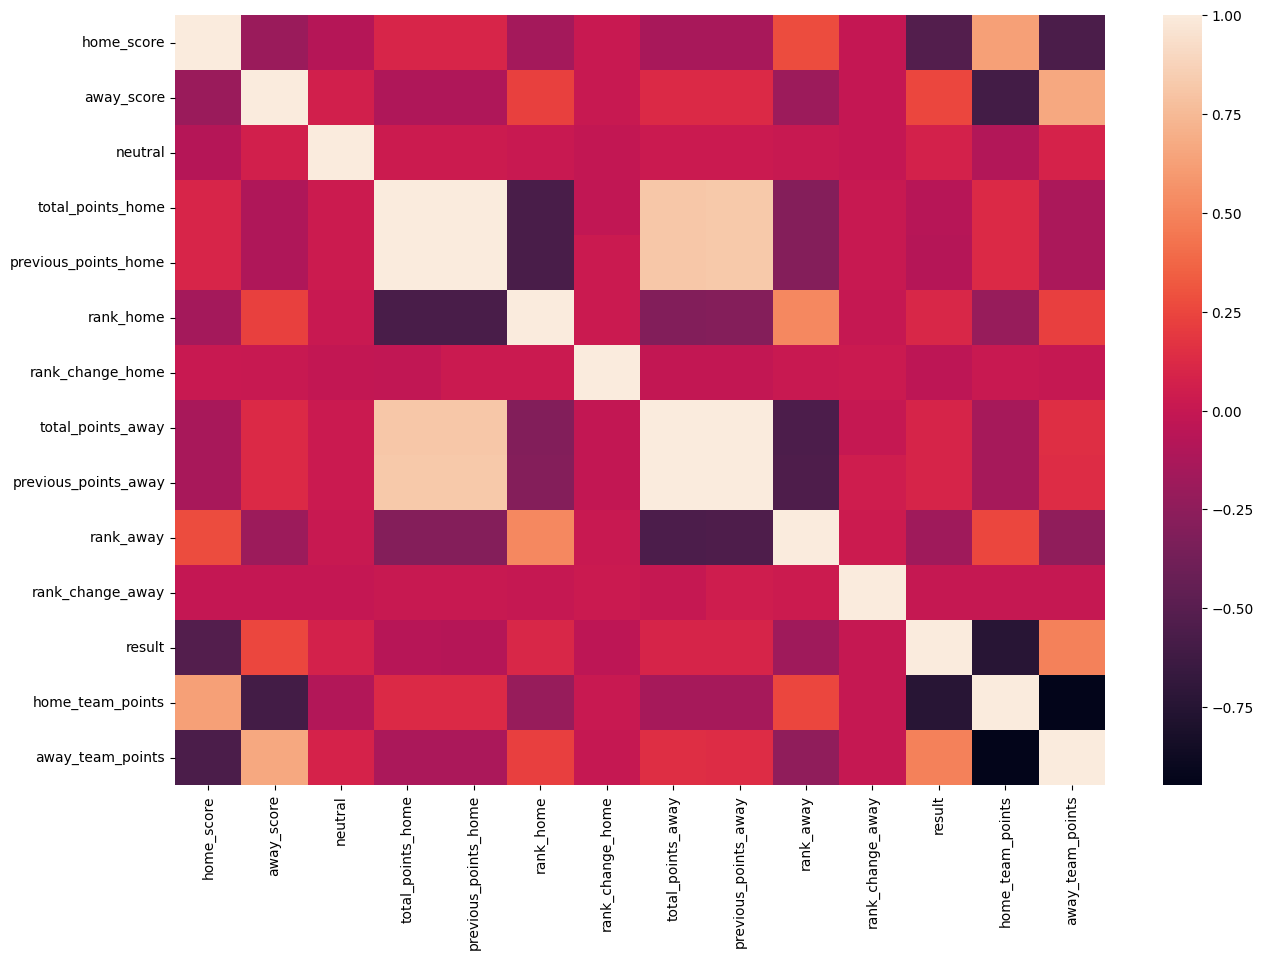

In [102]:
plt.figure(figsize=(15, 10))
sns.heatmap(fifa_rr_2k14_onwards.corr())
plt.show()

FIFA Rank Points and FIFA Rankings are negatively correlated for both home and away teams. They will be removed from the training data. 

Add features to the dataset: 


*   Ranking Difference (Home minus Away)
*   Points won over the team rank (for home and away teams)
*   Goals difference



In [103]:
fifa_rr_2k14_onwards['rank_dif'] = fifa_rr_2k14_onwards['rank_home'] - fifa_rr_2k14_onwards['rank_away']
fifa_rr_2k14_onwards['points_home_by_rank'] = fifa_rr_2k14_onwards['home_team_points'] / fifa_rr_2k14_onwards['rank_away']
fifa_rr_2k14_onwards['points_away_by_rank'] = fifa_rr_2k14_onwards['away_team_points'] / fifa_rr_2k14_onwards['rank_home']
fifa_rr_2k14_onwards['goals_diff'] = fifa_rr_2k14_onwards['home_score'] - fifa_rr_2k14_onwards['away_score']

Separate the dataset into two new datasets: one for home team and one for away team.

In [104]:
home_team_2k14 = fifa_rr_2k14_onwards[['date', 'home_team', 'home_score', 'away_score', 'rank_home', 'rank_away','rank_change_home', 'total_points_home', 'result', 'rank_dif', 'points_home_by_rank', 'home_team_points']]

away_team_2k14 = fifa_rr_2k14_onwards[['date', 'away_team', 'away_score', 'home_score', 'rank_away', 'rank_home','rank_change_away', 'total_points_away', 'result', 'rank_dif', 'points_away_by_rank', 'away_team_points']]

away_team_2k14.tail()

,date,away_team,away_score,home_score,rank_away,rank_home,rank_change_away,total_points_away,result,rank_dif,points_away_by_rank,away_team_points
6640,2022-12-14,Maldives,0,3,154.0,146.0,-2.0,1026.09,0,-8.0,0.000000,0
6641,2022-12-14,Philippines,0,1,133.0,96.0,-1.0,1115.13,0,-37.0,0.000000,0
6642,2022-12-17,Morocco,1,2,22.0,12.0,-1.0,1563.50,0,-10.0,0.000000,0
6643,2022-12-17,Maldives,1,3,154.0,160.0,-2.0,1026.09,0,6.0,0.000000,0
6644,2022-12-18,France,3,3,4.0,3.0,0.0,1759.78,2,-1.0,0.333333,1


Modify column names

In [105]:
home_team_2k14.columns = [h.replace('home_', '').replace('_home', '').replace('away_', 'suf_').replace('_away', '_suf') for h in home_team_2k14.columns]

away_team_2k14.columns = [a.replace('away_', '').replace('_away', '').replace('home_', 'suf_').replace('_home', '_suf') for a in away_team_2k14.columns]

away_team_2k14.tail()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
6640,2022-12-14,Maldives,0,3,154.0,146.0,-2.0,1026.09,0,-8.0,0.000000,0
6641,2022-12-14,Philippines,0,1,133.0,96.0,-1.0,1115.13,0,-37.0,0.000000,0
6642,2022-12-17,Morocco,1,2,22.0,12.0,-1.0,1563.50,0,-10.0,0.000000,0
6643,2022-12-17,Maldives,1,3,154.0,160.0,-2.0,1026.09,0,6.0,0.000000,0
6644,2022-12-18,France,3,3,4.0,3.0,0.0,1759.78,2,-1.0,0.333333,1


Concatenate the two datasets (row-wise) to simplify computations.

In [106]:
team_stats_2k14 = home_team_2k14.append(away_team_2k14)#.sort_values("date")
team_stats_2k14.head()

<ipython-input-106-d4342b30a443>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats_2k14 = home_team_2k14.append(away_team_2k14)#.sort_values("date")


,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2014-07-19,Botswana,2,0,99.0,136.0,7.0,332.0,0,-37.0,0.022059,3
1,2014-07-19,Sierra Leone,2,0,64.0,182.0,10.0,469.0,0,-118.0,0.016484,3
2,2014-07-19,Uganda,2,0,87.0,133.0,1.0,358.0,0,-46.0,0.022556,3
3,2014-07-20,Benin,1,0,91.0,121.0,4.0,354.0,0,-30.0,0.024793,3
4,2014-07-20,Congo,2,0,82.0,109.0,-3.0,375.0,0,-27.0,0.027523,3


In [107]:
team_stats_2k14s_raw = team_stats_2k14.copy()

Create predictive features: 


*   Mean goals of the team in World Cup Cycle.
*   Mean goals of the team in last 5 games.
*   Mean goals suffered of the team in World Cup Cycle.
*   Mean goals suffered of the team in last 5 games.
*   Mean FIFA Rank that team faced in World Cup Cycle.
*   Mean FIFA Rank that team faced in last 5 games.
*   FIFA Points won at the cycle.
*   FIFA Points won in last 5 games.
*   Mean game points at the Cycle.
*   Mean game points at last 5 games.
*   Mean game points by rank faced at the Cycle.
*   Mean game points by rank faced at last 5 games." 
from the Kaggle tutorial



In [108]:
stats_val = []
# length of the simple moving average
n = 5

for index, row in team_stats_2k14.iterrows():
    team = row['team']
    date = row['date']

    past_games = team_stats_2k14.loc[(team_stats_2k14['team'] == team) & (team_stats_2k14['date'] < date)] \
    .sort_values(by=['date'], ascending=False)
    previous_n = past_games.head(n)
    
    mean_goals = past_games['score'].mean()
    mean_goals_n = previous_n['score'].mean()
    
    mean_goals_suf = past_games['suf_score'].mean()
    mean_goals_suf_n = previous_n['suf_score'].mean()
    
    mean_rank = past_games['rank_suf'].mean()
    mean_rank_n = previous_n['rank_suf'].mean()
    
    if len(previous_n) > 0:
        mean_points = past_games['total_points'].values[0] - past_games['total_points'].values[-1]
        mean_points_n = previous_n['total_points'].values[0] - previous_n['total_points'].values[-1] 
    else:
        mean_points = 0
        mean_points_n = 0
        
    mean_gp = past_games['team_points'].mean()
    mean_gp_n = previous_n['team_points'].mean()
    
    mean_gp_rank = past_games['points_by_rank'].mean()
    mean_gp_rank_n = previous_n['points_by_rank'].mean()
    
    stats_val.append([mean_goals, mean_goals_n, mean_goals_suf, mean_goals_suf_n, 
                      mean_rank, mean_rank_n, mean_points, mean_points_n, 
                      mean_gp, mean_gp_n, mean_gp_rank, mean_gp_rank_n])


Concatenate the predictive features with `team_stats_2k14` 

In [109]:
stats_cols = ['mean_goals', 'mean_goals_n', 'mean_goals_suf', 'mean_goals_suf_n', 
                      'mean_rank', 'mean_rank_n', 'mean_points', 'mean_points_n', 
                      'mean_gp', 'mean_gp_n', 'mean_gp_rank', 'mean_gp_rank_n']

predictive_features = pd.DataFrame(stats_val, columns=stats_cols)

full_team_stats_2k14 = pd.concat([team_stats_2k14.reset_index(drop=True), predictive_features], 
                    axis=1, ignore_index=False)

Reconstruct the `away_team_2k14` and `home_team_2k14` datasets with the new features

In [110]:
home_team_stats_2k14 = full_team_stats_2k14.iloc[:int(full_team_stats_2k14.shape[0]/2),:]
away_team_stats_2k14 = full_team_stats_2k14.iloc[int(full_team_stats_2k14.shape[0]/2):,:]

home_team_stats_2k14.columns[-12:]

Index(['mean_goals', 'mean_goals_n', 'mean_goals_suf', 'mean_goals_suf_n',
       'mean_rank', 'mean_rank_n', 'mean_points', 'mean_points_n', 'mean_gp',
       'mean_gp_n', 'mean_gp_rank', 'mean_gp_rank_n'],
      dtype='object')

Add suffix to each relevant columns

In [111]:
home_team_stats_2k14 = home_team_stats_2k14[home_team_stats_2k14.columns[-12:]]
away_team_stats_2k14 = away_team_stats_2k14[away_team_stats_2k14.columns[-12:]]

home_team_stats_2k14.columns = ['home_'+str(col) for col in home_team_stats_2k14.columns]
away_team_stats_2k14.columns = ['away_'+str(col) for col in away_team_stats_2k14.columns]

In [112]:
home_team_stats_2k14.columns

Index(['home_mean_goals', 'home_mean_goals_n', 'home_mean_goals_suf',
       'home_mean_goals_suf_n', 'home_mean_rank', 'home_mean_rank_n',
       'home_mean_points', 'home_mean_points_n', 'home_mean_gp',
       'home_mean_gp_n', 'home_mean_gp_rank', 'home_mean_gp_rank_n'],
      dtype='object')

Unify main dataset

In [113]:
match_stats_2k14 = pd.concat([home_team_stats_2k14, away_team_stats_2k14.reset_index(drop=True)],
                        axis=1, ignore_index=False)

main_dataset_2k14 = pd.concat([fifa_rr_2k14_onwards, match_stats_2k14.reset_index(drop=True)],
                              axis=1, ignore_index=False)

main_dataset_2k14.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'points_home_by_rank', 'points_away_by_rank', 'goals_diff',
       'home_mean_goals', 'home_mean_goals_n', 'home_mean_goals_suf',
       'home_mean_goals_suf_n', 'home_mean_rank', 'home_mean_rank_n',
       'home_mean_points', 'home_mean_points_n', 'home_mean_gp',
       'home_mean_gp_n', 'home_mean_gp_rank', 'home_mean_gp_rank_n',
       'away_mean_goals', 'away_mean_goals_n', 'away_mean_goals_suf',
       'away_mean_goals_suf_n', 'away_mean_rank', 'away_mean_rank_n',
       'away_mean_points', 'away_mean_points_n', 'away_mean_gp',
       'away_mean_gp_n', 'away_mean_gp_rank', 'away_mean_gp_rank_n'],
      dtype='object')

Add a feature for the importance of the game

In [114]:
def find_friendly(x):
    if x == 'Friendly':
        return 1
    else: return 0

main_dataset_2k14['is_friendly'] = main_dataset_2k14['tournament'].apply(lambda x: find_friendly(x)) 
main_dataset_2k14 = pd.get_dummies(main_dataset_2k14, columns=['is_friendly'])

In [115]:
main_dataset_2k14.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'points_home_by_rank', 'points_away_by_rank', 'goals_diff',
       'home_mean_goals', 'home_mean_goals_n', 'home_mean_goals_suf',
       'home_mean_goals_suf_n', 'home_mean_rank', 'home_mean_rank_n',
       'home_mean_points', 'home_mean_points_n', 'home_mean_gp',
       'home_mean_gp_n', 'home_mean_gp_rank', 'home_mean_gp_rank_n',
       'away_mean_goals', 'away_mean_goals_n', 'away_mean_goals_suf',
       'away_mean_goals_suf_n', 'away_mean_rank', 'away_mean_rank_n',
       'away_mean_points', 'away_mean_points_n', 'away_mean_gp',
       'away_mean_gp_n', 'away_mean_gp_rank', 'away_mean_gp_rank_n',
       'is_friendly_0', 'i

Select only the relevant features for analysis

In [116]:
clean_dataset_2k14 = main_dataset_2k14[['date', 'home_team', 'away_team', 'rank_home', 'rank_away', 
                                        'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home', 'rank_change_away', 'home_mean_goals', 'home_mean_goals_n', 
                                        'home_mean_goals_suf', 'home_mean_goals_suf_n', 
                                        'home_mean_rank', 'home_mean_rank_n',
                                        'home_mean_points', 'home_mean_points_n', 
                                        'away_mean_goals', 'away_mean_goals_n', 
                                        'away_mean_goals_suf', 'away_mean_goals_suf_n', 
                                        'away_mean_rank', 'away_mean_rank_n', 
                                        'away_mean_points', 'away_mean_points_n', 
                                        'home_mean_gp', 'home_mean_gp_n', 
                                        'home_mean_gp_rank', 'home_mean_gp_rank_n', 
                                        'away_mean_gp', 'away_mean_gp_n', 
                                        'away_mean_gp_rank', 'away_mean_gp_rank_n', 
                                        'is_friendly_0', 'is_friendly_1']]

clean_dataset_2k14.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_mean_gp,home_mean_gp_n,home_mean_gp_rank,home_mean_gp_rank_n,away_mean_gp,away_mean_gp_n,away_mean_gp_rank,away_mean_gp_rank_n,is_friendly_0,is_friendly_1
6640,2022-12-14,Malaysia,Maldives,146.0,154.0,3,0,0,-8.0,-2.0,...,1.440476,1.6,0.009254,0.010218,1.127273,1.8,0.006406,0.009363,0,1
6641,2022-12-14,Vietnam,Philippines,96.0,133.0,1,0,0,-37.0,-1.0,...,1.656250,2.0,0.012699,0.022238,1.224138,0.8,0.007866,0.004550,0,1
6642,2022-12-17,Croatia,Morocco,12.0,22.0,2,1,0,-10.0,-3.0,...,1.788462,1.2,0.095453,0.322967,2.071429,2.0,0.054340,0.409872,1,0
6643,2022-12-17,Singapore,Maldives,160.0,154.0,3,1,0,6.0,1.0,...,1.164384,1.0,0.007831,0.007240,1.107143,1.8,0.006291,0.009363,0,1
6644,2022-12-18,Argentina,France,3.0,4.0,3,3,2,-1.0,0.0,...,2.074766,2.6,0.181932,0.160020,2.220183,2.4,0.174791,0.230350,1,0


In [117]:
clean_dataset_2k14.isna().sum()

date                       0
home_team                  0
away_team                  0
rank_home                  0
rank_away                  0
home_score                 0
away_score                 0
result                     0
rank_dif                   0
rank_change_home           0
rank_change_away           0
home_mean_goals          104
home_mean_goals_n        104
home_mean_goals_suf      104
home_mean_goals_suf_n    104
home_mean_rank           104
home_mean_rank_n         104
home_mean_points           0
home_mean_points_n         0
away_mean_goals           97
away_mean_goals_n         97
away_mean_goals_suf       97
away_mean_goals_suf_n     97
away_mean_rank            97
away_mean_rank_n          97
away_mean_points           0
away_mean_points_n         0
home_mean_gp             104
home_mean_gp_n           104
home_mean_gp_rank        104
home_mean_gp_rank_n      104
away_mean_gp              97
away_mean_gp_n            97
away_mean_gp_rank         97
away_mean_gp_r

NA values appear for the first n games to initialize the simple moving average. Those values are removed from the dataset. 

In [118]:
clean_dataset_2k14_no_na = clean_dataset_2k14.dropna()

# 3. Data Analysis

Analyze features for predictive power.
Replace useless ones.

Assign loses to the home team when there is a draw to create a binary problem. Now the result variable can only have two values: 
- `0` - The home team won
- `1` - The away team won

The value `2` which used to represent a draw was replaced with a `1`, to change all draws to a vicotry for the away team and to create a binary problem. 

To analyse the importance of features, we will do violin and box plots of each one, comparing the features when there is a `0` or a `1` as the result. The best features with the higher predictive power are thoes that show a difference in their distribution between each result. 

In [119]:
dataset_2k14 = clean_dataset_2k14_no_na

In [120]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
dataset_2k14['target'] = dataset_2k14['result'].apply(lambda x: no_draw(x))

<ipython-input-120-288e114ceca4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2k14['target'] = dataset_2k14['result'].apply(lambda x: no_draw(x))


In [121]:
def normalize(data): 
  normalized = (data[:-1] - data[:-1].mean()) / data[:-1].std()
  return normalized

data1 = dataset_2k14[list(dataset_2k14.columns[8:20].values) + ['target']]
data2 = dataset_2k14[dataset_2k14.columns[20:]]

scaled = normalize(data1)
scaled['target'] = data1['target']
violin1 = pd.melt(scaled,id_vars='target', var_name='features', value_name='value')

scaled = normalize(data2)
scaled['target'] = data2['target']
violin2 = pd.melt(scaled,id_vars='target', var_name='features', value_name='value')

In [122]:
def showViolin(violin):
  plt.figure(figsize=(15,7))
  sns.violinplot(x='features', y='value', hue='target', data=violin, split=True, inner='quart', palette=["gold", "red"])
  plt.xticks(rotation=90)
  plt.ylim(-10, 10) # set the y-axis limits to be between -10 and 10
  plt.show()

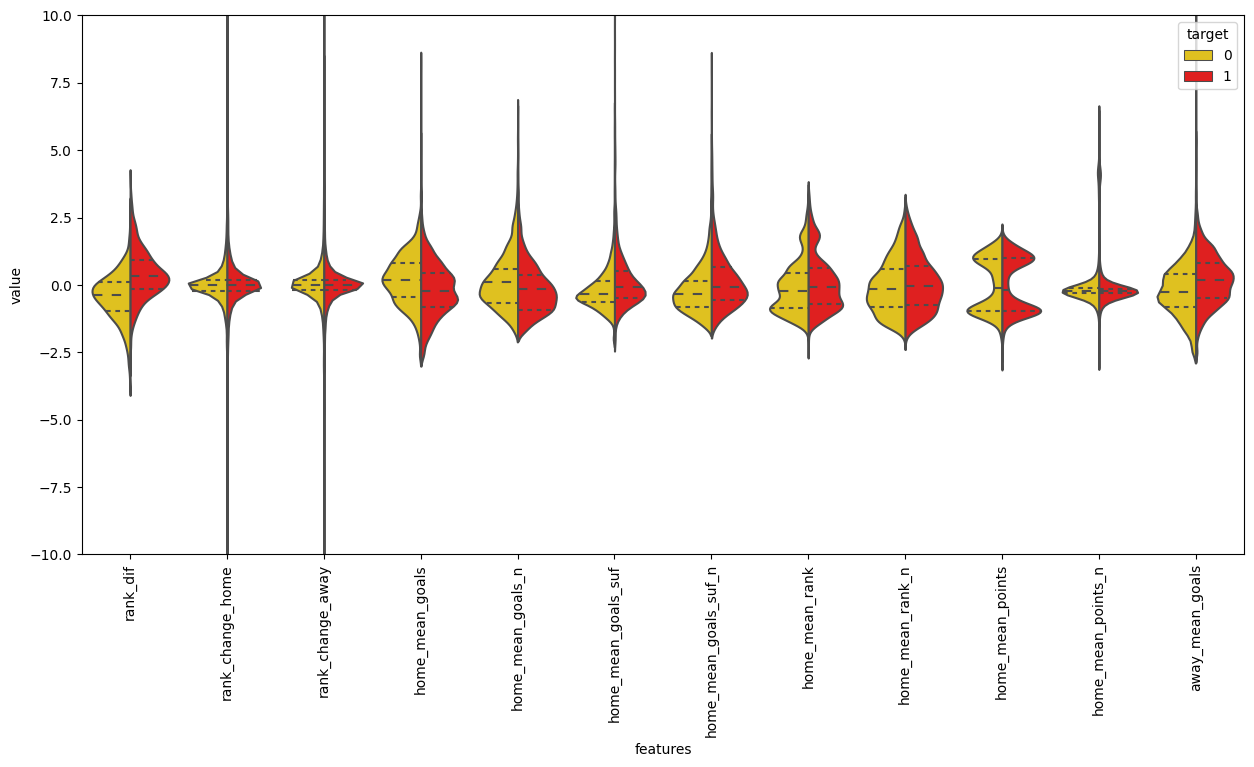

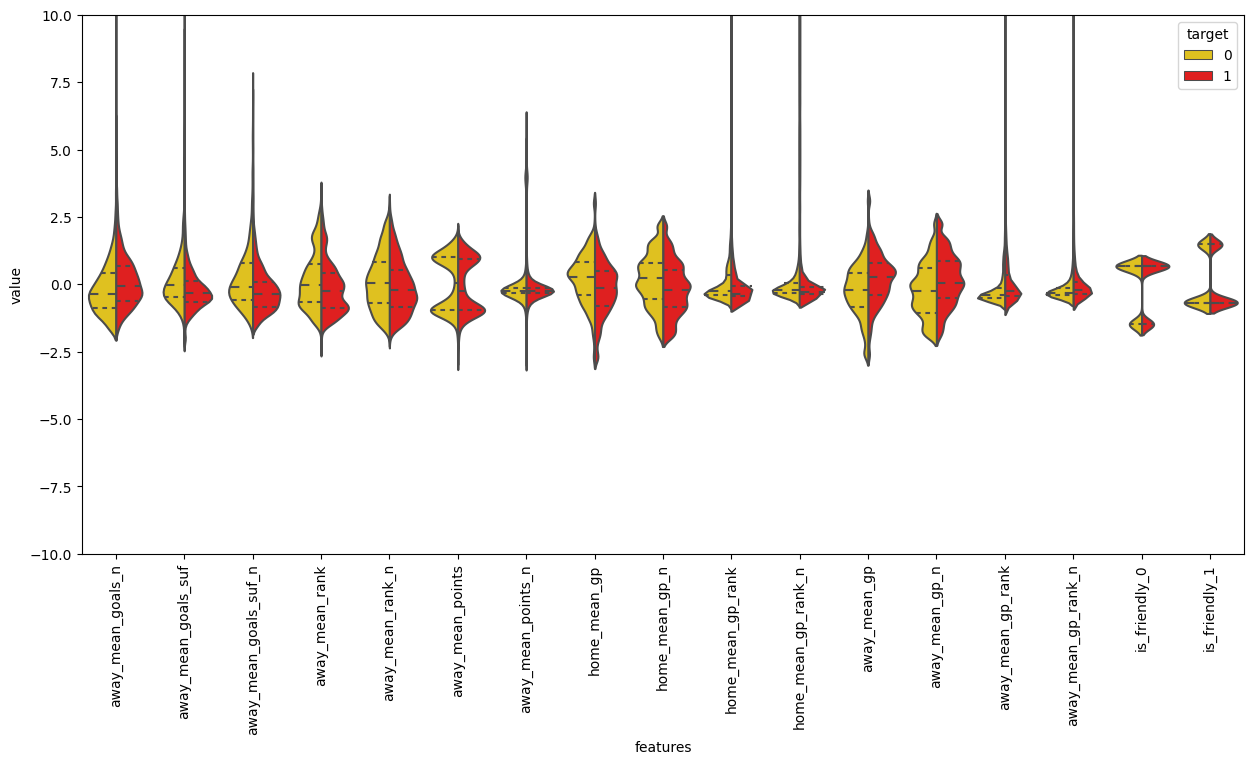

In [123]:
showViolin(violin1)
showViolin(violin2)

`rank_dif` is "the only good separator of the data", since there is a clear distcintction between the 0 and 1 target values.

Try to get other differences by adding new features using old ones

In [124]:
cp_dataset_2k14 = dataset_2k14.copy()
cp_dataset_2k14.loc[:, 'goals_dif'] = cp_dataset_2k14['home_mean_goals'] - cp_dataset_2k14['away_mean_goals']
cp_dataset_2k14.loc[:, 'goals_dif_n'] = cp_dataset_2k14['home_mean_goals_n'] - cp_dataset_2k14['away_mean_goals_n']
cp_dataset_2k14.loc[:, 'goals_suf_dif'] = cp_dataset_2k14['home_mean_goals_suf'] - cp_dataset_2k14['away_mean_goals_suf']
cp_dataset_2k14.loc[:, 'goals_suf_dif_n'] = cp_dataset_2k14['home_mean_goals_suf_n'] - cp_dataset_2k14['away_mean_goals_suf_n']
cp_dataset_2k14.loc[:, 'goals_made_suf_dif'] = cp_dataset_2k14['home_mean_goals'] - cp_dataset_2k14['away_mean_goals_suf']
cp_dataset_2k14.loc[:, 'goals_made_suf_dif_n'] = cp_dataset_2k14['home_mean_goals_n'] - cp_dataset_2k14['away_mean_goals_suf_n']
cp_dataset_2k14.loc[:, 'goals_suf_made_dif'] = cp_dataset_2k14['home_mean_goals_suf'] - cp_dataset_2k14['away_mean_goals']
cp_dataset_2k14.loc[:, 'goals_suf_made_dif_n'] = cp_dataset_2k14['home_mean_goals_suf_n'] - cp_dataset_2k14['away_mean_goals_n']

In [125]:
data_difs = cp_dataset_2k14.iloc[:, -8:]

scaled = normalize(data_difs)
scaled["target"] = data2["target"]
violin3 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

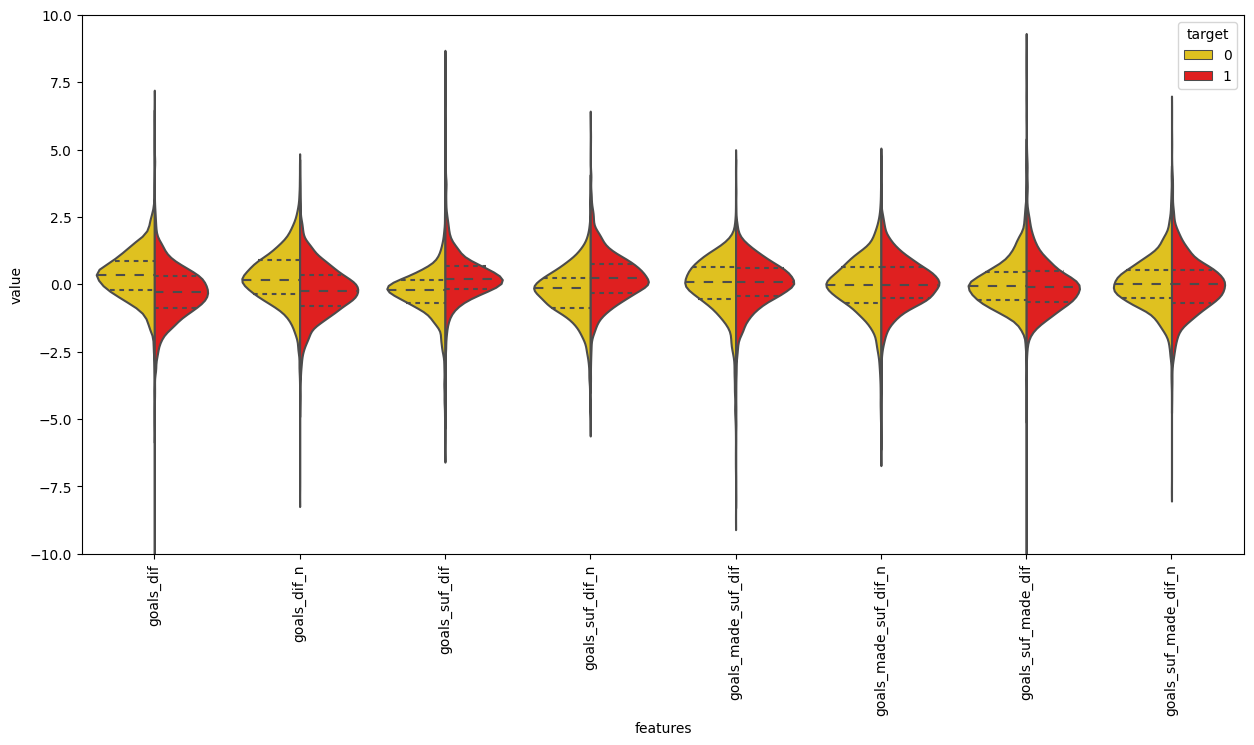

In [126]:
showViolin(violin3)

Goal difference and goal suffered difference are good data separators, as shown bu the difference between the 0 and 1 target values. 

Create other differences.

In [127]:
cp_dataset_2k14.loc[:, 'dif_points'] = cp_dataset_2k14['home_mean_gp'] - cp_dataset_2k14['away_mean_gp']
cp_dataset_2k14.loc[:, 'dif_points_n'] = cp_dataset_2k14['home_mean_gp_n'] - cp_dataset_2k14['away_mean_gp_n']
cp_dataset_2k14.loc[:, 'dif_points_rank'] = cp_dataset_2k14['home_mean_gp_rank'] - cp_dataset_2k14['away_mean_gp_rank']
cp_dataset_2k14.loc[:, 'dif_points_rank_n'] = cp_dataset_2k14['home_mean_gp_rank_n'] - cp_dataset_2k14['away_mean_gp_rank_n']
cp_dataset_2k14.loc[:, 'dif_rank_agst'] = cp_dataset_2k14['home_mean_rank'] - cp_dataset_2k14['away_mean_rank']
cp_dataset_2k14.loc[:, 'dif_rank_agst_n'] = cp_dataset_2k14['home_mean_rank_n'] - cp_dataset_2k14['away_mean_rank_n']

cp_dataset_2k14.loc[:, 'goals_per_ranking_dif'] = (cp_dataset_2k14['home_mean_goals'] / cp_dataset_2k14['home_mean_rank']) \
                                                - (cp_dataset_2k14['away_mean_goals'] / cp_dataset_2k14['away_mean_rank'])
cp_dataset_2k14.loc[:, 'goals_per_ranking_suf_dif'] = (cp_dataset_2k14['home_mean_goals_suf'] / cp_dataset_2k14['home_mean_rank']) \
                                                    - (cp_dataset_2k14['away_mean_goals_suf'] / cp_dataset_2k14['away_mean_rank'])
cp_dataset_2k14.loc[:, 'goals_per_ranking_dif_n'] = (cp_dataset_2k14['home_mean_goals_n'] / cp_dataset_2k14['home_mean_rank']) \
                                                  - (cp_dataset_2k14['away_mean_goals_n'] / cp_dataset_2k14['away_mean_rank'])
cp_dataset_2k14.loc[:, 'goals_per_ranking_suf_dif_n'] = (cp_dataset_2k14['home_mean_goals_suf_n'] / cp_dataset_2k14['home_mean_rank']) \
                                                      - (cp_dataset_2k14['away_mean_goals_suf_n'] / cp_dataset_2k14['away_mean_rank'])

In [128]:
data_difs2 = cp_dataset_2k14.iloc[:, -10:]
scaled = normalize(data_difs2)
scaled["target"] = data2["target"]
violin4 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

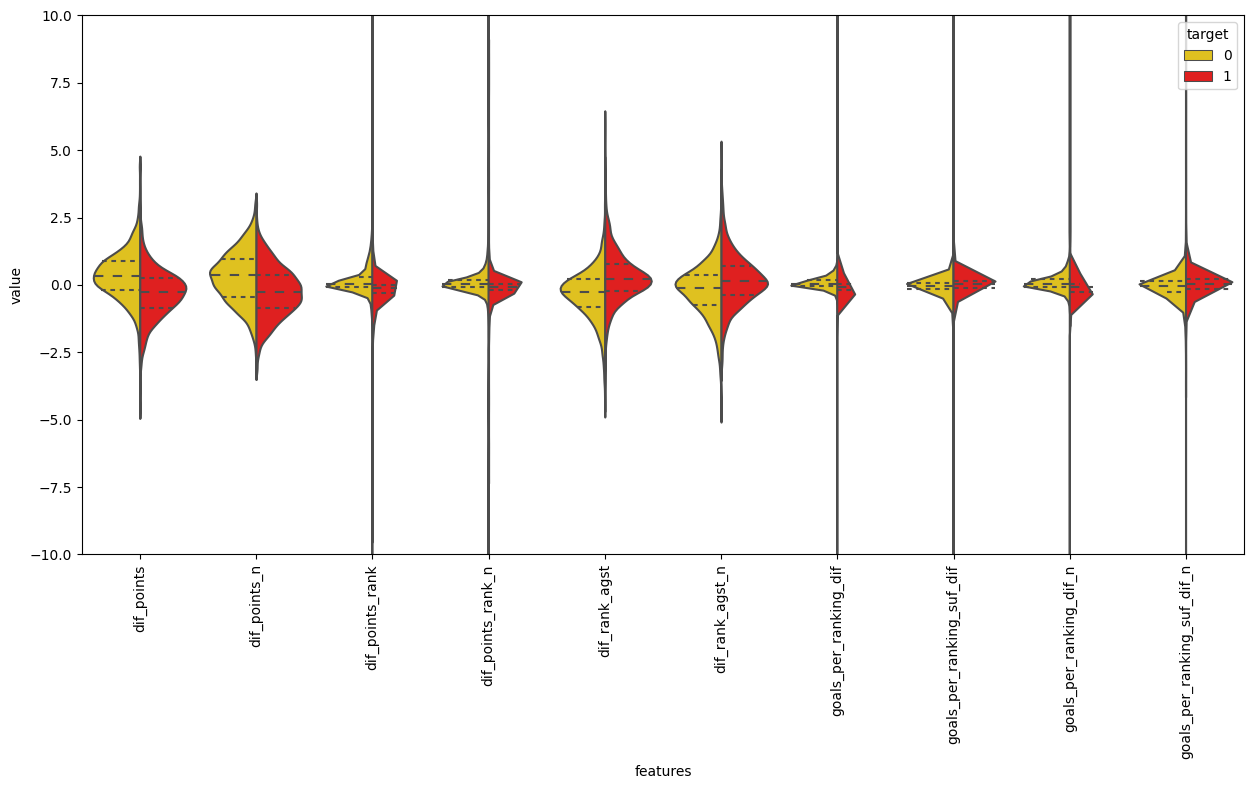

In [129]:
showViolin(violin4)

Violin plot is not the best option, becasuse the values are two close together to distinguish whether there is a difference between the 0 and 1 target values. Consider boxplot instead. 

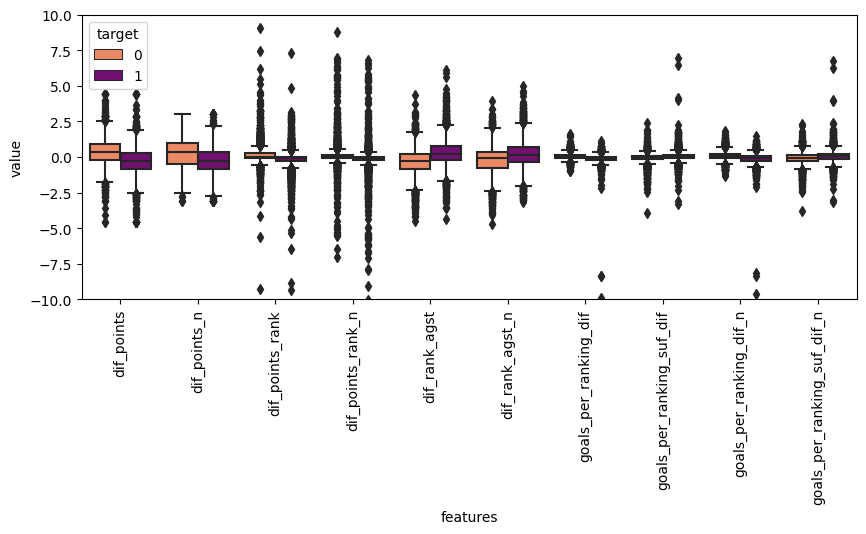

In [130]:
plt.figure(figsize=(10, 3.7))
sns.boxplot(x="features", y="value", hue="target", data=violin4, palette=["coral", "purple"])
plt.xticks(rotation=90)
plt.ylim(-10, 10)
plt.show()

Difference of points, difference of points by ranking faced and difference of rank faced are good features.

Plot correlated features

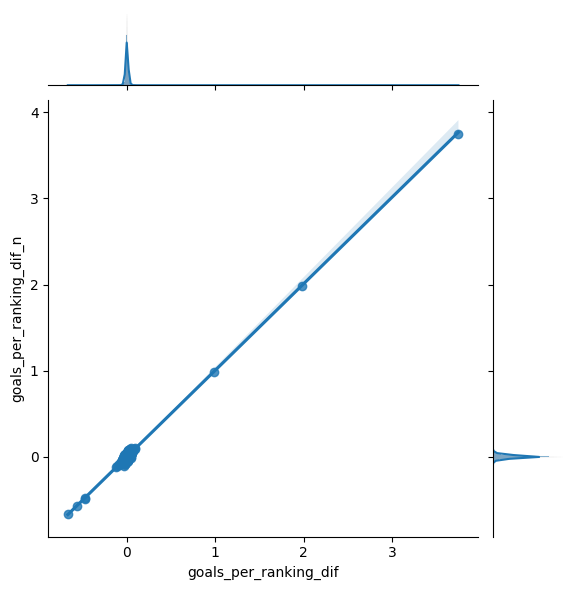

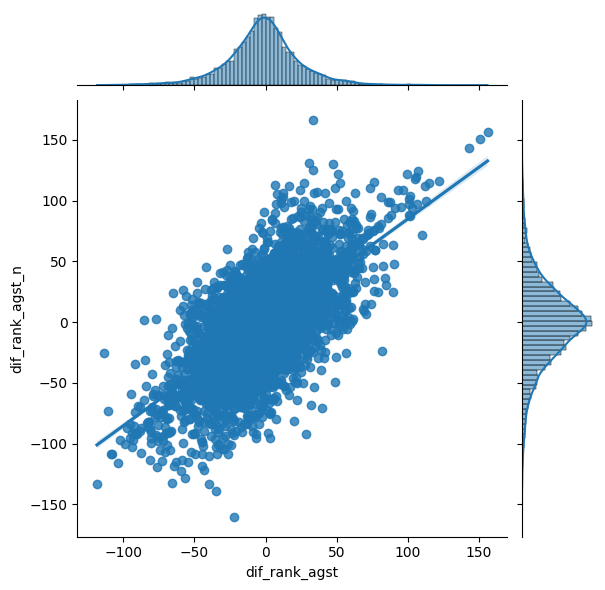

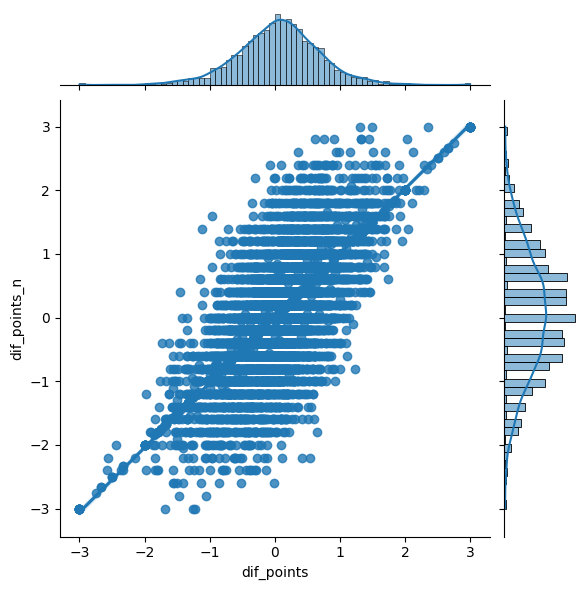

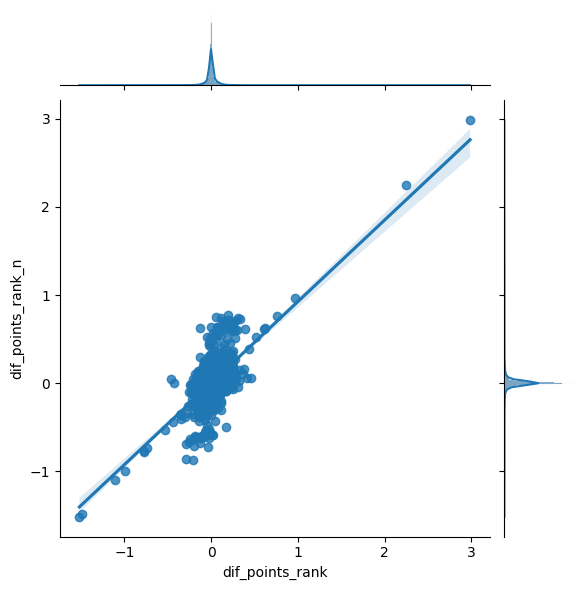

In [131]:
def showRegPlot(data, x, y):
  sns.jointplot(data = data, x = x, y = y, kind="reg")
  plt.show()

showRegPlot(data_difs2, 'goals_per_ranking_dif', 'goals_per_ranking_dif_n')
showRegPlot(data_difs2, 'dif_rank_agst', 'dif_rank_agst_n')
showRegPlot(data_difs2, 'dif_points', 'dif_points_n')
showRegPlot(data_difs2, 'dif_points_rank', 'dif_points_rank_n')


Since `goals_per_ranking_dif` and `goals_per_ranking_dif_n` are almost perfectly correlated, `goals_per_ranking_dif` is kept out of the two. For the other features, the differences are enough to justify using both in the model.

The final features are:

* rank_dif
* goals_dif
* goals_dif_n
* goals_suf_dif
* goals_suf_dif_n
* dif_rank_agst
* dif_rank_agst_n
* goals_per_ranking_dif
* dif_points_rank
* dif_points_rank_n
* is_friendly
from the Kaggle tutorial.

You can see that all the final features are differences - i.e they result from data processing and are not raw. This supports the fact that raw features as less powerful than processed ones, and indicates that were we to do more experiments with the poisson distribution and ranking methods from the original paper, we could obtain even more important features. 

Function to create a processed dataset. No date column, ensure the dates are good before creating the final dataset.

In [132]:
def create_dataset(df):
  columns = ['home_team', 'away_team', 'target', 'rank_dif', 'home_mean_goals', 'home_mean_rank', 
              'away_mean_goals', 'away_mean_rank', 'home_mean_rank_n', 'away_mean_rank_n', 
              'home_mean_goals_suf', 'away_mean_goals_suf', 'home_mean_goals_n', 'away_mean_goals_n', 
              'home_mean_goals_suf_n', 'away_mean_goals_suf_n', 'home_mean_gp_rank', 'home_mean_gp_rank_n', 
              'away_mean_gp_rank', 'away_mean_gp_rank_n','is_friendly_0', 'is_friendly_1']

  base = df.loc[:, columns]
  # Features - processed as a difference bewteen two other features
  base.loc[:, 'goals_dif'] = base['home_mean_goals'] - base['away_mean_goals']
  base.loc[:, 'goals_dif_n'] = base['home_mean_goals_n'] - base['away_mean_goals_n']
  base.loc[:, 'goals_suf_dif'] = base['home_mean_goals_suf'] - base['away_mean_goals_suf']
  base.loc[:, 'goals_suf_dif_n'] = base['home_mean_goals_suf_n'] - base['away_mean_goals_suf_n']
  base.loc[:, 'goals_per_ranking_dif'] = (base['home_mean_goals'] / base['home_mean_rank']) \
                                                  - (base['away_mean_goals'] / base['away_mean_rank'])
  base.loc[:, 'dif_rank_agst'] = base['home_mean_rank'] - base['away_mean_rank']
  base.loc[:, 'dif_rank_agst_n'] = base['home_mean_rank_n'] - base['away_mean_rank_n']
  base.loc[:, 'dif_points_rank'] = base['home_mean_gp_rank'] - base['away_mean_gp_rank']
  base.loc[:, 'dif_points_rank_n'] = base['home_mean_gp_rank_n'] - base['away_mean_gp_rank_n']
  
  model_df = base[['home_team', 'away_team', 'target', 'rank_dif', 'goals_dif', 'goals_dif_n', 
                   'goals_suf_dif', 'goals_suf_dif_n', 'goals_per_ranking_dif', 
                   'dif_rank_agst', 'dif_rank_agst_n', 'dif_points_rank', 'dif_points_rank_n', 
                   'is_friendly_0', 'is_friendly_1']]
                   
  return model_df
# ['date', 'home_team', 'away_team', 'rank_home', 'rank_away', 
#                                         'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home', 'rank_change_away', 'home_mean_goals', 'home_mean_goals_n', 
#                                         'home_mean_goals_suf', 'home_mean_goals_suf_n', 
#                                         'home_mean_rank', 'home_mean_rank_n',
#                                         'home_mean_points', 'home_mean_points_n', 
#                                         'away_mean_goals', 'away_mean_goals_n', 
#                                         'away_mean_goals_suf', 'away_mean_goals_suf_n', 
#                                         'away_mean_rank', 'away_mean_rank_n', 
#                                         'away_mean_points', 'away_mean_points_n', 
#                                         'home_mean_gp', 'home_mean_gp_n', 
#                                         'home_mean_gp_rank', 'home_mean_gp_rank_n', 
#                                         'away_mean_gp', 'away_mean_gp_n', 
#                                         'away_mean_gp_rank', 'away_mean_gp_rank_n', 
#                                         'is_friendly_0', 'is_friendly_1']

Select only the matches before the WC22

In [133]:
prior_to_wc18 = dataset_2k14[(dataset_2k14['date'] <= '2018-6-13')].reset_index(drop=True)
prior_to_wc18.tail(10)

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_mean_gp_n,home_mean_gp_rank,home_mean_gp_rank_n,away_mean_gp,away_mean_gp_n,away_mean_gp_rank,away_mean_gp_rank_n,is_friendly_0,is_friendly_1,target
2919,2018-06-09,Latvia,Azerbaijan,129.0,105.0,1,3,1,24.0,-10.0,...,1.0,0.013683,0.010017,0.838710,0.2,0.010109,0.001205,0,1,1
2920,2018-06-09,Finland,Belarus,63.0,78.0,2,0,0,-15.0,1.0,...,2.0,0.034449,0.023758,1.166667,1.6,0.027960,0.020353,0,1,0
2921,2018-06-09,Tunisia,Spain,21.0,10.0,0,1,1,11.0,7.0,...,1.8,0.034223,0.098963,2.051282,1.8,0.169427,0.413683,0,1,1
2922,2018-06-09,France,United States,7.0,25.0,1,1,2,-18.0,0.0,...,2.0,0.158372,0.258879,1.666667,1.6,0.106441,0.102456,0,1,1
2923,2018-06-10,Austria,Brazil,26.0,2.0,0,3,1,24.0,0.0,...,3.0,0.120610,0.661291,2.363636,2.6,0.306284,0.673160,0,1,1
2924,2018-06-10,India,Kenya,97.0,112.0,2,0,0,-15.0,0.0,...,2.0,0.011411,0.013271,1.297297,1.4,0.012467,0.010164,1,0,0
2925,2018-06-11,South Korea,Senegal,57.0,27.0,0,2,1,30.0,-4.0,...,0.8,0.028340,0.013559,2.068182,1.2,0.032500,0.018174,0,1,1
2926,2018-06-11,Belgium,Costa Rica,3.0,23.0,4,1,0,-20.0,0.0,...,2.2,0.071145,0.097875,1.553191,1.2,0.052766,0.040972,0,1,0
2927,2018-06-12,Japan,Paraguay,61.0,32.0,4,2,0,29.0,1.0,...,0.2,0.022982,0.002985,0.923077,1.2,0.169826,0.145714,0,1,0
2928,2018-06-12,Poland,Lithuania,8.0,126.0,4,0,0,-118.0,-2.0,...,1.0,0.139774,0.044156,0.676471,0.8,0.009228,0.008032,0,1,0


In [134]:
model_dataset = create_dataset(prior_to_wc18)

# 4. Random Forest Model

From the Kaggle tutorial, 1 model is tested: Random Forests. The metric used for model selection will be recall.

Separate features from label.

In [135]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [136]:
x = model_dataset.iloc[:, 3:]
y = model_dataset[['target']]
print(x.shape)
# 80/20 training-test split
# random_state to control instance shuffling 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=1)
print(x_train.shape)
print(x_test.shape)

(2929, 12)
(2343, 12)
(586, 12)


## 4.1 Random Forest

In [137]:
# removed 30 from options for max depth to save time since it was not chosen
# removed 10 from min samples split since it was not chosen
params_rf = {"max_depth": [None,5,10,20],
                "min_samples_split": [20,30,40],
                "max_leaf_nodes": [None,175],
                "min_samples_leaf": [1,5],
                "n_estimators": [100,250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = True)

rf_cv.fit(x_train.values, np.ravel(y_train))

# Found number of parameters with the help of Chat GPT
# Access the individual trees in the random forest
trees = rf_cv.best_estimator_.estimators_

# Calculate the total number of nodes in all trees
total_nodes = sum(tree.tree_.node_count for tree in trees)

# Estimate the number of parameters in the random forest
n_params = total_nodes + len(trees) * (1 + x_train.shape[1])
print(n_params)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
44964


In [138]:
rf = rf_cv.best_estimator_
rf
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


## 4.2 Analyze In-Sample Performance

In [139]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [140]:
def analyze(model):
  # fpr: false positive rate, tpr: true positive rate
  fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test.values)[:,1]) #test AUC
  plt.figure(figsize=(15,10))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label="test")

  fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(x_train.values)[:,1]) #train AUC
  plt.plot(fpr_train, tpr_train, label="train")
  auc_test = roc_auc_score(y_test, model.predict_proba(x_test.values)[:,1])
  auc_train = roc_auc_score(y_train, model.predict_proba(x_train.values)[:,1])
  plt.legend()
  plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
  plt.show()
  
  plt.figure(figsize=(15, 10))
  cm = confusion_matrix(y_test, model.predict(x_test.values))
  sns.heatmap(cm, annot=True, fmt="d")

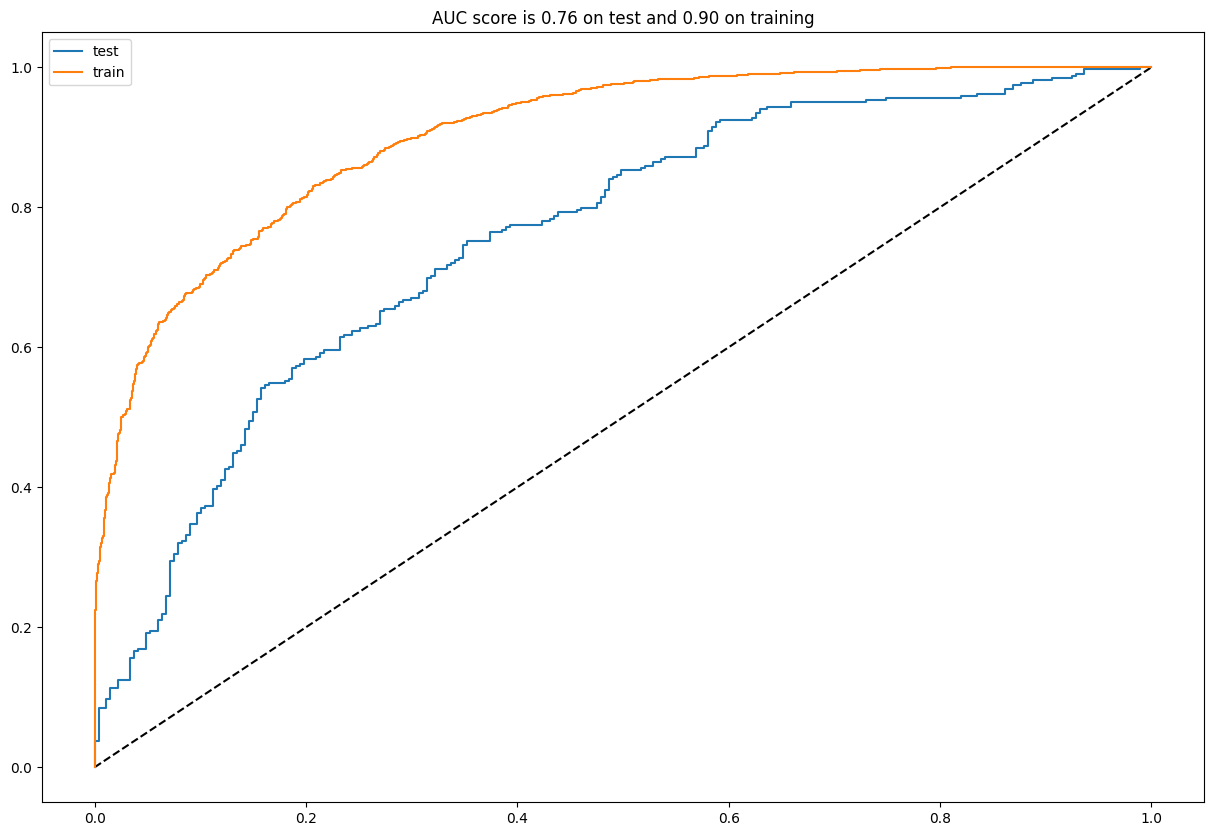

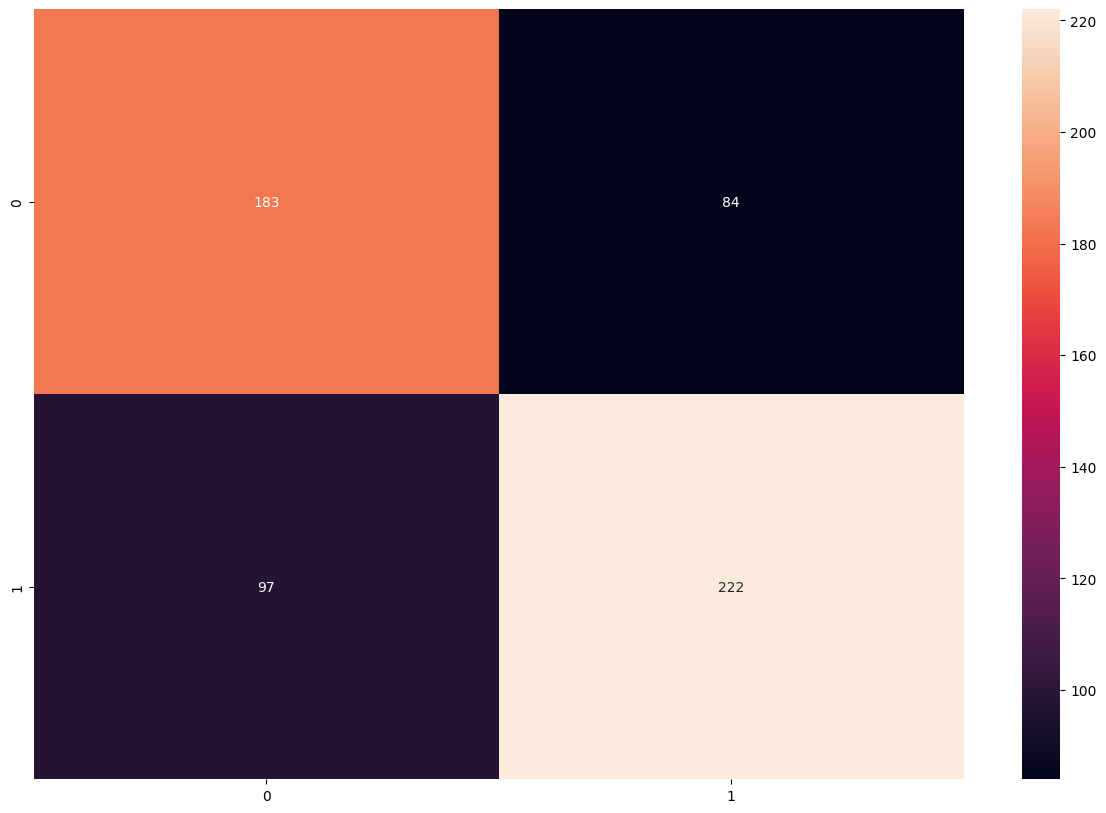

In [141]:
analyze(rf)

# 5. WC Simulation

While this code was adapted from the Kaggle tutorial, it was greatly adjusted to become more modular so that the world cup could be simulated multiple times

The Kaggle tutorial chose Gradient Boosting for simulating the WC22.

In [142]:
from operator import itemgetter

Object containing the teams in the different groups

In [143]:
wc18_groups = {
    'A': [['Uruguay', 0, []],
          ['Russia', 0, []],
          ['Saudi Arabia', 0, []],
          ['Egypt', 0, []]],
    'B': [['Spain', 0, []],
          ['Portugal', 0, []],
          ['Iran', 0, []],
          ['Morocco', 0, []]],
    'C': [['France', 0, []],
          ['Denmark', 0, []],
          ['Peru', 0, []],
          ['Australia', 0, []]],
    'D': [['Croatia', 0, []],
          ['Argentina', 0, []],
          ['Nigeria', 0, []],
          ['Iceland', 0, []]],
    'E': [['Brazil', 0, []],
          ['Costa Rica', 0, []],
          ['Switzerland', 0, []],
          ['Serbia', 0, []]],
    'F': [['Sweden', 0, []],
          ['Mexico', 0, []],
          ['South Korea', 0, []],
          ['Germany', 0, []]],
    'G': [['Belgium', 0, []],
          ['England', 0, []],
          ['Tunisia', 0, []],
          ['Panama', 0, []]],
    'H': [['Colombia', 0, []],
          ['Japan', 0, []],
          ['Senegal', 0, []],
          ['Poland', 0, []]]
  }

Create a list of the group matches

In [144]:
def get_key_by_value(d, elem):
    for key, value in d.items():
        if any(elem in sublist for sublist in value):
            return key
    raise ValueError('Value not found in dictionary')

In [145]:
group_matches = []

for row in range(48):
  home_team = wc18.loc[row, 'home_team']
  away_team = wc18.loc[row, 'away_team']
  if get_key_by_value(wc18_groups, home_team) == get_key_by_value(wc18_groups, away_team):
    group_matches.append((get_key_by_value(wc18_groups, home_team), home_team, away_team))

group_matches = sorted(group_matches, key=lambda x: x[0])
group_matches


[('A', 'Russia', 'Saudi Arabia'),
 ('A', 'Egypt', 'Uruguay'),
 ('A', 'Russia', 'Egypt'),
 ('A', 'Uruguay', 'Saudi Arabia'),
 ('A', 'Russia', 'Uruguay'),
 ('A', 'Saudi Arabia', 'Egypt'),
 ('B', 'Morocco', 'Iran'),
 ('B', 'Portugal', 'Spain'),
 ('B', 'Portugal', 'Morocco'),
 ('B', 'Iran', 'Spain'),
 ('B', 'Spain', 'Morocco'),
 ('B', 'Iran', 'Portugal'),
 ('C', 'France', 'Australia'),
 ('C', 'Peru', 'Denmark'),
 ('C', 'Denmark', 'Australia'),
 ('C', 'France', 'Peru'),
 ('C', 'Australia', 'Peru'),
 ('C', 'Denmark', 'France'),
 ('D', 'Argentina', 'Iceland'),
 ('D', 'Croatia', 'Nigeria'),
 ('D', 'Argentina', 'Croatia'),
 ('D', 'Nigeria', 'Iceland'),
 ('D', 'Nigeria', 'Argentina'),
 ('D', 'Iceland', 'Croatia'),
 ('E', 'Costa Rica', 'Serbia'),
 ('E', 'Brazil', 'Switzerland'),
 ('E', 'Brazil', 'Costa Rica'),
 ('E', 'Serbia', 'Switzerland'),
 ('E', 'Serbia', 'Brazil'),
 ('E', 'Switzerland', 'Costa Rica'),
 ('F', 'Germany', 'Mexico'),
 ('F', 'Sweden', 'South Korea'),
 ('F', 'South Korea', 'Mexico

Before doing the analysis, the WC matches from the dataset `team_stats_2k14s_raw` need to be removed.

In [146]:
team_stats_prior_wc18 = team_stats_2k14s_raw[(team_stats_2k14s_raw['date'] <= '2018-6-13')].reset_index(drop=True)
team_stats_prior_wc18.tail()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
6139,2018-06-10,Kenya,0,2,112.0,97.0,1.0,291.0,0,-15.0,0.000000,0
6140,2018-06-11,Senegal,2,0,27.0,57.0,-1.0,838.0,1,30.0,0.052632,3
6141,2018-06-11,Costa Rica,1,4,23.0,3.0,-2.0,884.0,0,-20.0,0.000000,0
6142,2018-06-12,Paraguay,2,4,32.0,61.0,0.0,773.0,0,29.0,0.000000,0
6143,2018-06-12,Lithuania,0,4,126.0,8.0,-7.0,239.0,0,-118.0,0.000000,0


Find the stats for a team based on their five last games

In [147]:
def find_stats(team, n=5):
    past_games = team_stats_prior_wc18[(team_stats_prior_wc18['team'] == team)].sort_values('date')
    last_n = team_stats_prior_wc18[(team_stats_prior_wc18['team'] == team)].sort_values('date').tail(n)

    team_rank = past_games['rank'].values[-1]
    team_goals = past_games.score.mean()
    team_goals_n = last_n.score.mean()
    team_goals_suf = past_games.suf_score.mean()
    team_goals_suf_n = last_n.suf_score.mean()
    team_rank_suf = past_games.rank_suf.mean()
    team_rank_suf_n = last_n.rank_suf.mean()
    team_gp_rank = past_games.points_by_rank.mean()
    team_gp_rank_n = last_n.points_by_rank.mean()

    return [team_rank, team_goals, team_goals_n, team_goals_suf, team_goals_suf_n, team_rank_suf, team_rank_suf_n, team_gp_rank, team_gp_rank_n]

# run once to speed up computation
wc18_teams = ['Uruguay', 'Russia', 'Saudi Arabia', 'Egypt', 'Spain', 'Portugal', 'Iran', 'Morocco', 'France', 'Denmark', 'Peru', 'Australia', 'Croatia', 'Argentina', 'Nigeria', 'Iceland', 'Brazil', 'Costa Rica', 'Switzerland', 'Serbia', 'Sweden', 'Mexico', 'South Korea', 'Germany', 'Belgium', 'England', 'Tunisia', 'Panama', 'Colombia', 'Japan', 'Senegal', 'Poland']
wc18_stats = {}

for team in wc18_teams:
    wc18_stats[team] = find_stats(team)

In [148]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_n = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_n = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_n = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_n = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_n, goals_suf_dif, goals_suf_dif_n, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_n, dif_gp_rank, dif_gp_rank_n, 1, 0]

The model simulates if the home team will win or not. Assume at the WC, there is no home advantage. (Look if home advantage could be useful eventually.) To remove the home team bias, the probabilities are calculated considering each of the team as the home team, the highest average of these 2 values determines the winner.

If in this prediction the winning team is different in both cases, this is treated as a draw

Group stage simulation

The model from the paper uses this:

rf = RandomForestClassifier(n_estimators=100, max_depth=20,
                              random_state=0)


Our model uses this 


rf = RandomForestClassifier(max_depth=20, min_samples_split=10, max_leaf_nodes=175, min_samples_leaf=5, n_estimators=250, max_features='sqrt')

In [149]:
def run_gs_simulation(model, verbose=False):
    advanced_group = []
    last_group = ''

    # Initialize wc22_groups (done already)
    for k in wc18_groups.keys():
        for t in wc18_groups[k]:
            t[1] = 0
            t[2] = []
            
    for teams in group_matches:
        draw = False

        team_1 = wc18_stats[teams[1]]
        team_2 = wc18_stats[teams[2]]

        features_g1 = find_features(team_1, team_2)
        features_g2 = find_features(team_2, team_1)
        # calling the model
        probs_g1 = model.predict_proba([features_g1])
        probs_g2 = model.predict_proba([features_g2])
        
        team_1_prob_g1 = probs_g1[0][0]
        team_1_prob_g2 = probs_g2[0][1]
        team_2_prob_g1 = probs_g1[0][1]
        team_2_prob_g2 = probs_g2[0][0]
        # averaging probabilities
        team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
        team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
        # Draw
        if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
            draw=True
            for i in wc18_groups[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1
        # team_1 wins          
        elif team_1_prob > team_2_prob:
            winner = teams[1]
            winner_proba = team_1_prob
            for i in wc18_groups[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
        # team_2 loses             
        elif team_2_prob > team_1_prob:  
            winner = teams[2]
            winner_proba = team_2_prob
            for i in wc18_groups[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        # Append probabilities for each team
        for i in wc18_groups[teams[0]]:
                if i[0] == teams[1]:
                    i[2].append(team_1_prob)
                if i[0] == teams[2]:
                    i[2].append(team_2_prob)

        if last_group != teams[0]:
            if last_group != '':
                if verbose:
                    print('\n')
                    print('Group %s advanced: '%(last_group))
                
                for i in wc18_groups[last_group]:
                    i[2] = np.mean(i[2])
                
                final_points = wc18_groups[last_group]
                final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
                advanced_group.append([final_table[0][0], final_table[1][0]])
                if verbose:
                    for i in final_table:
                        print('%s -------- %d'%(i[0], i[1]))
            if verbose:
                print('\n')
                print('-'*10+' Starting Analysis for Group %s '%(teams[0])+'-'*10)
            
        if verbose:    
            if draw == False:
                print('Group %s - %s vs. %s: Winner %s with %.2f probability'%(teams[0], teams[1], teams[2], winner, winner_proba))
            else:
                print('Group %s - %s vs. %s: Draw'%(teams[0], teams[1], teams[2]))
        last_group = teams[0]
    
    if verbose:
        print('\n')
        print('Group %s advanced: '%(last_group))

    for i in wc18_groups[last_group]:
        i[2] = np.mean(i[2])
                
    final_points = wc18_groups[last_group]
    final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
    advanced_group.append([final_table[0][0], final_table[1][0]])
    if verbose:
        for i in final_table:
            print('%s -------- %d'%(i[0], i[1]))
    return advanced_group


rf = RandomForestClassifier(max_depth=20, min_samples_split=10, max_leaf_nodes=175, min_samples_leaf=5, n_estimators=250, max_features='sqrt')
rf.fit(x_train.values, np.ravel(y_train))
advanced_group = run_gs_simulation(rf, verbose=True)



---------- Starting Analysis for Group A ----------
Group A - Russia vs. Saudi Arabia: Winner Russia with 0.61 probability
Group A - Egypt vs. Uruguay: Winner Uruguay with 0.71 probability
Group A - Russia vs. Egypt: Winner Russia with 0.54 probability
Group A - Uruguay vs. Saudi Arabia: Winner Uruguay with 0.80 probability
Group A - Russia vs. Uruguay: Winner Uruguay with 0.75 probability
Group A - Saudi Arabia vs. Egypt: Draw


Group A advanced: 
Uruguay -------- 9
Russia -------- 6
Egypt -------- 1
Saudi Arabia -------- 1


---------- Starting Analysis for Group B ----------
Group B - Morocco vs. Iran: Draw
Group B - Portugal vs. Spain: Winner Spain with 0.61 probability
Group B - Portugal vs. Morocco: Winner Portugal with 0.55 probability
Group B - Iran vs. Spain: Winner Spain with 0.80 probability
Group B - Spain vs. Morocco: Winner Spain with 0.74 probability
Group B - Iran vs. Portugal: Winner Portugal with 0.71 probability


Group B advanced: 
Spain -------- 9
Portugal ------

We can now simulate up to the final. Now that we have entered the playoffs, we assume that a draw is not possible, and after predicting two games where each team plays at home, and the average probability of the two games is taken, the team with the higher probaility advances. 

In [150]:
def run_playoffs_simulation(model, advanced, round='Full', verbose=False):
    # modifications were made this code to make it modular
    # the round parameter allows for simulations of individual rounds
    if round == 'Full':
        playoffs = {'Round of 16': [], 'Quarter-Final': [], 'Semi-Final': [], 'Final': []}
    else:
        playoffs = {round: []}

    actual_round = ''
    next_rounds = []
    for p in playoffs.keys():
        if p == 'Round of 16':
            control = []
            for a in range(0, len(advanced*2), 1):
                if a < len(advanced):
                    if a % 2 == 0:
                        control.append((advanced*2)[a][0])
                    else:
                        control.append((advanced*2)[a][1])
                else:
                    if a % 2 == 0:
                        control.append((advanced*2)[a][1])
                    else:
                        control.append((advanced*2)[a][0])

            playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
            
            for i in range(0, len(playoffs[p]), 1):
                game = playoffs[p][i]
                
                home = game[0]
                away = game[1]
                team_1 = wc18_stats[home]
                team_2 = wc18_stats[away]

                features_g1 = find_features(team_1, team_2)
                features_g2 = find_features(team_2, team_1)
                
                probs_g1 = model.predict_proba([features_g1])
                probs_g2 = model.predict_proba([features_g2])
                
                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
                
                if verbose:
                    if actual_round != p:
                        print('-'*10)
                        print('Starting simulation of %s'%(p))
                        print('-'*10)
                        print('\n')
                
                if team_1_prob < team_2_prob:
                    if verbose:
                        print('%s vs. %s: %s advances with prob %.2f'%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose:
                        print('%s vs. %s: %s advances with prob %.2f'%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
            if round != 'Full':
                return playoffs, next_rounds
            
        else:
            if round != 'Full':
                playoffs[p] = [[advanced[c], advanced[c+1]] for c in range(0, len(advanced)-1, 1) if c%2 == 0]
            else:
                playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]

            next_rounds = []
            
            for i in range(0, len(playoffs[p])):
                game = playoffs[p][i]
                home = game[0]
                away = game[1]
                team_1 = find_stats(home)
                team_2 = find_stats(away)
                
                features_g1 = find_features(team_1, team_2)
                features_g2 = find_features(team_2, team_1)
                
                probs_g1 = model.predict_proba([features_g1])
                probs_g2 = model.predict_proba([features_g2])
                
                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
                
                if verbose:
                    if actual_round != p:
                        print('-'*10)
                        print('Starting simulation of %s'%(p))
                        print('-'*10)
                        print('\n')
                
                if team_1_prob < team_2_prob:
                    if verbose:
                        print('%s vs. %s: %s advances with prob %.2f'%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose:
                        print('%s vs. %s: %s advances with prob %.2f'%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
            
            if round != 'Full':
                return playoffs, next_rounds

    return playoffs

playoffs = run_playoffs_simulation(rf, advanced_group, round='Full', verbose=True)
print(playoffs)

r16_results, advanced_r16 = run_playoffs_simulation(rf, advanced_group, round='Round of 16')
qf_results, advanced_qf = run_playoffs_simulation(rf, advanced_r16, round='Quarter-Final')
sf_results, advanced_sf = run_playoffs_simulation(rf, advanced_qf, round='Semi-Final')
f_results, winner = run_playoffs_simulation(rf, advanced_sf, round='Final')
playoffs = r16_results | qf_results | sf_results | f_results
print(playoffs)

----------
Starting simulation of Round of 16
----------


Uruguay vs. Portugal: Uruguay advances with prob 0.55
France vs. Croatia: France advances with prob 0.74
Brazil vs. Mexico: Brazil advances with prob 0.70
Belgium vs. Colombia: Belgium advances with prob 0.54
Russia vs. Spain: Spain advances with prob 0.85
Peru vs. Argentina: Argentina advances with prob 0.64
Switzerland vs. Germany: Germany advances with prob 0.63
England vs. Poland: Poland advances with prob 0.50
----------
Starting simulation of Quarter-Final
----------


Uruguay vs. France: France advances with prob 0.71
Brazil vs. Belgium: Brazil advances with prob 0.56
Spain vs. Argentina: Spain advances with prob 0.54
Germany vs. Poland: Germany advances with prob 0.51
----------
Starting simulation of Semi-Final
----------


France vs. Brazil: Brazil advances with prob 0.67
Spain vs. Germany: Spain advances with prob 0.51
----------
Starting simulation of Final
----------


Brazil vs. Spain: Brazil advances with prob 0.

Visualize the World Cup

In [151]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

<ipython-input-152-0e7d5b3d4b81>:17: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


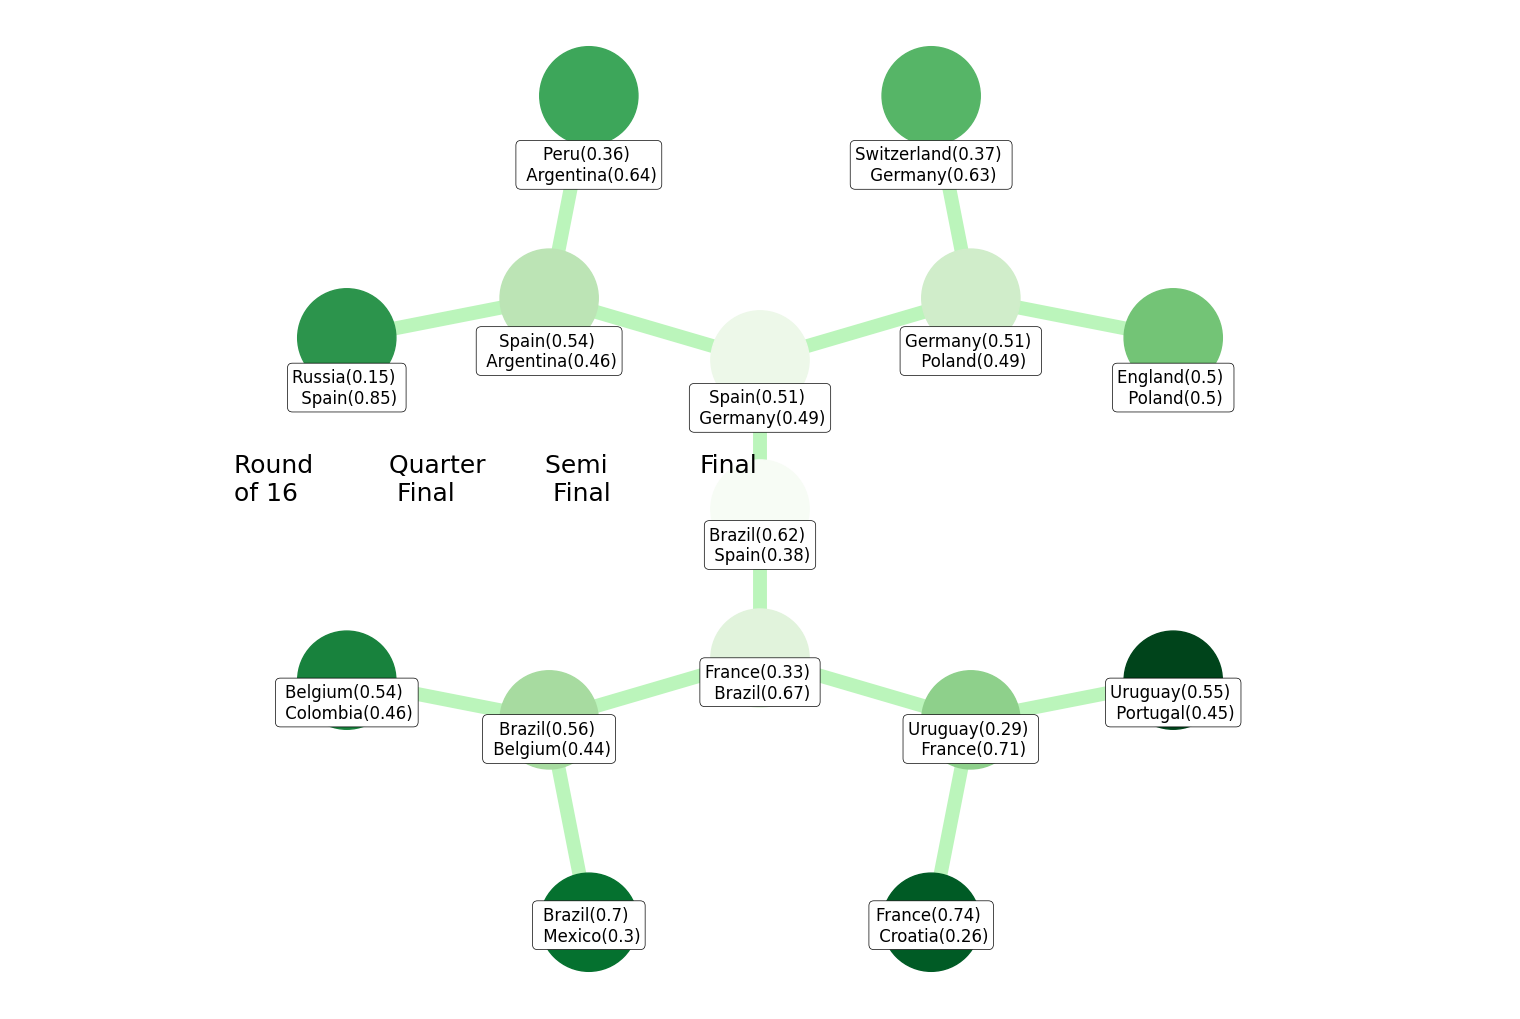

In [152]:
def plot_playoffs(model_playoffs):
    plt.figure(figsize=(15, 10))
    G = nx.balanced_tree(2, 3)
    labels = []

    for p in model_playoffs.keys():
        for game in model_playoffs[p]:
            label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
            labels.append(label)
        
    labels_dict = {}
    labels_rev = list(reversed(labels))

    for l in range(len(list(G.nodes))):
        labels_dict[l] = labels_rev[l]

    pos = graphviz_layout(G, prog='twopi')
    labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
    center  = pd.DataFrame(pos).mean(axis=1).mean()   

    nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color='#bbf5bb', width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
    nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=.5, alpha=1),
                            labels=labels_dict)
    texts = ['Round \nof 16', 'Quarter \n Final', 'Semi \n Final', 'Final\n']
    pos_y = pos[0][1] + 55
    for text in reversed(texts):
        pos_x = center
        pos_y -= 75 
        plt.text(pos_y, pos_x, text, fontsize = 18)

    plt.axis('equal')
    plt.show()

plot_playoffs(playoffs)

# Adjusting World Cup Simulation for 2018

To match the results of the paper that inspired this experiment, we will repeat the simulation as many times as our computation limits allow (100). Since it was not specified, we will do this in the most logical way: Average of Probabilities - the average of the chance of victory is taken for each team at each stage, and that is used to determine the winner

###5.1 Multiple Simulations

In [153]:
from scipy.stats import mode
# very slow, ~5s per simulation
num_sims = 100

#storing n models so we don not have to fit new models when simulating each round iteratively 
rf_models = []


advanced_sims = []
# group stage simulation
for i in range(num_sims):
    rf_model = RandomForestClassifier(max_depth=20, min_samples_split=10, max_leaf_nodes=175, min_samples_leaf=5, n_estimators=250, max_features='sqrt')
    rf_model.fit(x_train.values, np.ravel(y_train))
    rf_models.append(rf_model)
    advanced_group = run_gs_simulation(rf_model)
    # print(advanced_group)
    advanced_sims.append(advanced_group)
# advanced_group format: [[A1, A2], [B1, B2], ...]

# after n group stage simulations, find most frequent R16 bracket
# this set bracket will be used for n simulations in next round
set_bracket_r16 = [list(group) for group in list(mode(advanced_sims, axis=0, keepdims=True).mode[0])]
print(set_bracket_r16)

r16_matchups = []
r16_probs = []
# round of 16 simulation
for i in range(num_sims):
    rf_model = rf_models[i]
    r16_results, advanced_r16 = run_playoffs_simulation(rf_model, set_bracket_r16, round='Round of 16')
    # print(r16_results)
    instance_probs = []
    r16_matchups = []
    for game in r16_results['Round of 16']:
        r16_matchups.append(game[:2])
        instance_probs.append(game[2])
    r16_probs.append(instance_probs)

# after n R16 simulations, find mean probabilities
r16_mean_probs = np.mean(r16_probs, axis=0)
r16_mean_results = []
set_bracket_qf = []
for index, game in enumerate(r16_matchups):
    r16_mean_results.append([game[0], game[1], list(r16_mean_probs[index])])
    if r16_mean_probs[index][0] > 0.5:
        set_bracket_qf.append(game[0])
    else:
        set_bracket_qf.append(game[1])
# print(r16_mean_results)
# print(set_bracket_qf)

qf_matchups = []
qf_probs = []
# quarter finals simulation
for i in range(num_sims):
    rf_model = rf_models[i]
    qf_results, advanced_qf = run_playoffs_simulation(rf_model, set_bracket_qf, round='Quarter-Final')
    # print(qf_results)
    instance_probs = []
    qf_matchups = []
    for game in qf_results['Quarter-Final']:
        qf_matchups.append(game[:2])
        instance_probs.append(game[2])
    qf_probs.append(instance_probs)

# after n quarter finals simulations, find mean probabilities
qf_mean_probs = np.mean(qf_probs, axis=0)
qf_mean_results = []
set_bracket_sf = []
for index, game in enumerate(qf_matchups):
    qf_mean_results.append([game[0], game[1], list(qf_mean_probs[index])])
    if qf_mean_probs[index][0] > 0.5:
        set_bracket_sf.append(game[0])
    else:
        set_bracket_sf.append(game[1])
# print(qf_mean_results)
# print(set_bracket_sf)

sf_matchups = []
sf_probs = []
# semi finals simulation
for i in range(num_sims):
    rf_model = rf_models[i]
    sf_results, advanced_sf = run_playoffs_simulation(rf_model, set_bracket_sf, round='Semi-Final')
    # print(sf_results)
    instance_probs = []
    sf_matchups = []
    for game in sf_results['Semi-Final']:
        sf_matchups.append(game[:2])
        instance_probs.append(game[2])
    sf_probs.append(instance_probs)

# after n semi finals simulations, find mean probabilities
sf_mean_probs = np.mean(sf_probs, axis=0)
sf_mean_results = []
set_bracket_f = []
for index, game in enumerate(sf_matchups):
    sf_mean_results.append([game[0], game[1], list(sf_mean_probs[index])])
    if sf_mean_probs[index][0] > 0.5:
        set_bracket_f.append(game[0])
    else:
        set_bracket_f.append(game[1])
# print(sf_mean_results)
# print(set_bracket_f)

f_matchups = []
f_probs = []
# final simulation
for i in range(num_sims):
    rf_model = rf_models[i]
    f_results, advanced_f = run_playoffs_simulation(rf_model, set_bracket_f, round='Semi-Final')
    # print(f_results)
    instance_probs = []
    f_matchups = []
    for game in f_results['Semi-Final']:
        f_matchups.append(game[:2])
        instance_probs.append(game[2])
    f_probs.append(instance_probs)

# after n final simulations, find mean probabilities
f_mean_probs = np.mean(f_probs, axis=0)
f_mean_results = []
for index, game in enumerate(f_matchups):
    f_mean_results.append([game[0], game[1], list(f_mean_probs[index])])
# print(f_mean_results)

mean_playoffs = {'Round of 16': r16_mean_results, 'Quarter-Final': qf_mean_results, 'Semi-Final': sf_mean_results, 'Final': f_mean_results}
print(mean_playoffs)


<ipython-input-153-32b05278204b>:22: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  set_bracket_r16 = [list(group) for group in list(mode(advanced_sims, axis=0, keepdims=True).mode[0])]


[['Uruguay', 'Russia'], ['Spain', 'Portugal'], ['France', 'Peru'], ['Argentina', 'Croatia'], ['Brazil', 'Switzerland'], ['Germany', 'Mexico'], ['Belgium', 'England'], ['Colombia', 'Colombia']]
{'Round of 16': [['Uruguay', 'Portugal', [0.5400358570689026, 0.45996414293109744]], ['France', 'Croatia', [0.7157600943313124, 0.2842399056686876]], ['Brazil', 'Mexico', [0.7079358247879164, 0.2920641752120839]], ['Belgium', 'Colombia', [0.5369215908287825, 0.4630784091712175]], ['Russia', 'Spain', [0.15183578492119496, 0.8481642150788054]], ['Peru', 'Argentina', [0.3686421347027558, 0.631357865297244]], ['Switzerland', 'Germany', [0.3783256288794458, 0.6216743711205541]], ['England', 'Colombia', [0.49627499377625467, 0.5037250062237453]]], 'Quarter-Final': [['Uruguay', 'France', [0.2844372598715116, 0.7155627401284886]], ['Brazil', 'Belgium', [0.5427842232064767, 0.4572157767935234]], ['Spain', 'Argentina', [0.5368590760218723, 0.4631409239781277]], ['Germany', 'Colombia', [0.5537990024898777, 

Plotting Mean Results of knockout stage after 100 simulations

<ipython-input-152-0e7d5b3d4b81>:17: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


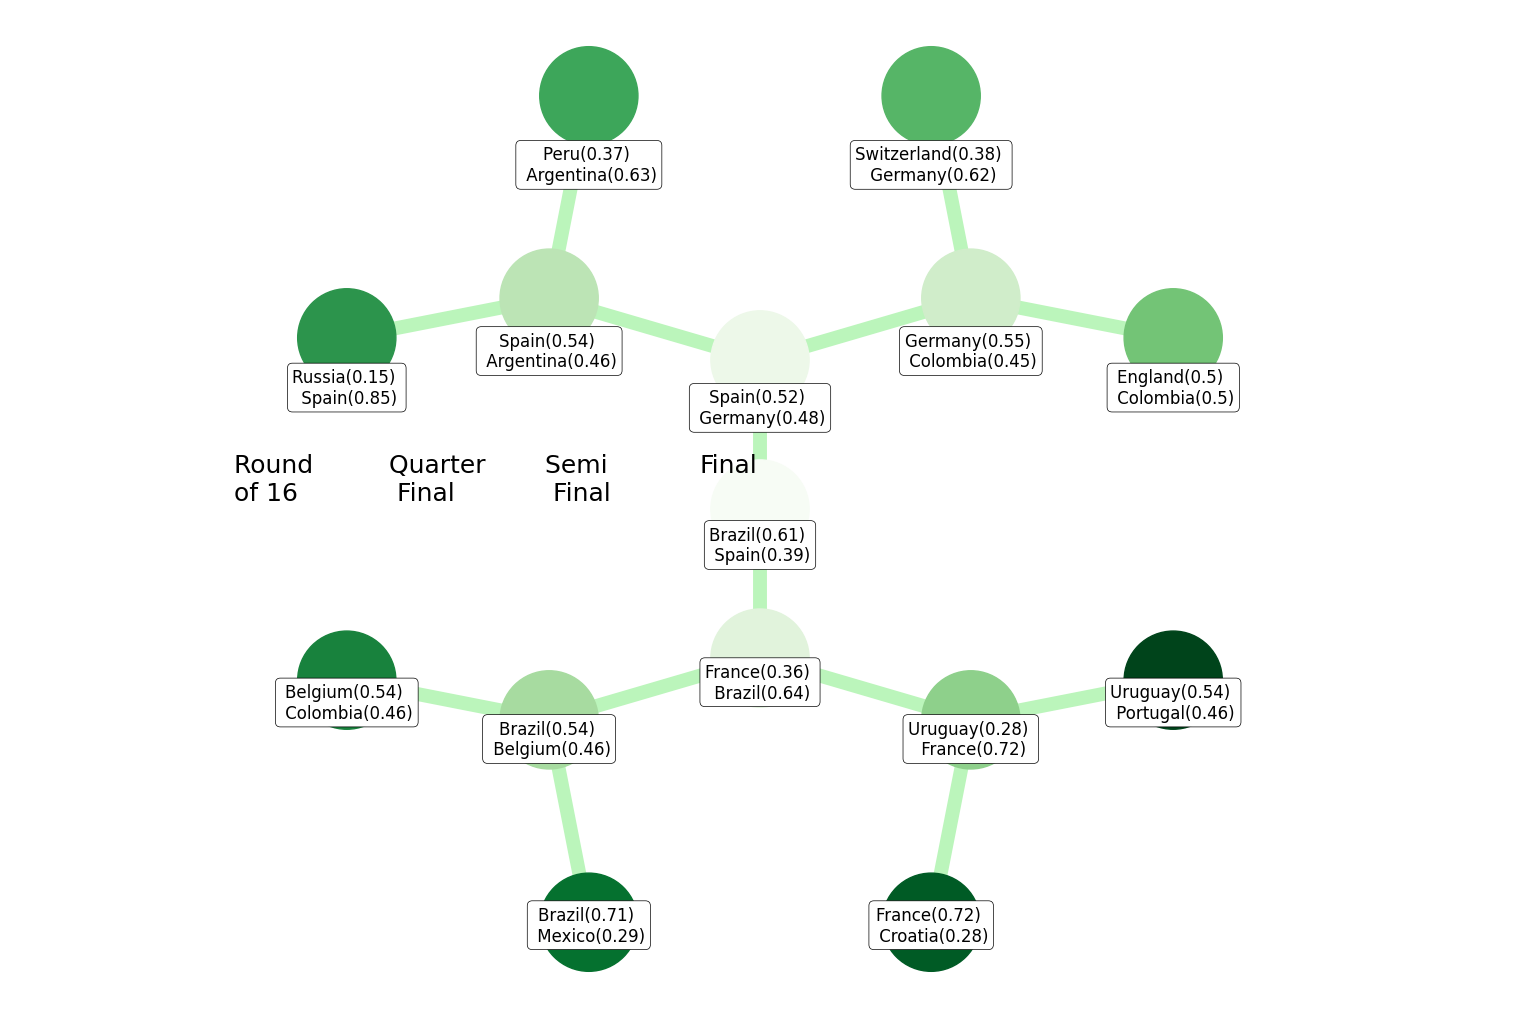

In [154]:
plot_playoffs(mean_playoffs)